In [1]:
from aif360.metrics import ClassificationMetric
from models import SimpleMLP
from dataset_readers import *
from sklearn.preprocessing import StandardScaler

import numpy as np
from util import mathew_correlation_coefficient, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
corr = None

`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

In [2]:
def eval(model, dataset, unprivileged_groups, privileged_groups):
    try:
        # sklearn classifier
        y_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
        y_pred = (y_pred_prob[:, 1] > 0.5).astype(np.float64)

        y_pred_mapped = y_pred.copy()
        # Map the dataset labels to back to their original values.
        y_pred_mapped[y_pred == 0] = dataset.unfavorable_label
        y_pred_mapped[y_pred == 1] = dataset.favorable_label

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_pred_mapped

    except AttributeError:
        # aif360 inprocessing algorithm
        y_pred = model.predict(dataset).labels
        y_pred_prob = model.predict_proba(dataset)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_pred

        # Map the dataset labels to back to their original values.
        temp_labels = dataset_pred.labels.copy()

        temp_labels[(dataset_pred.labels == 1.0).ravel(), 0] = dataset.favorable_label
        temp_labels[(dataset_pred.labels == 0.0).ravel(), 0] = dataset.unfavorable_label

        dataset_pred.labels = temp_labels.copy()
    metric = ClassificationMetric(
        dataset, dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)

    metrics = dict()
    metrics['overall_acc'] = abs(metric.accuracy())
    metrics['bal_acc'] = abs((metric.true_positive_rate()
                              + metric.true_negative_rate()) / 2)
    metrics['avg_odds_diff'] = metric.average_abs_odds_difference()
    metrics['disp_imp'] = abs(metric.disparate_impact())
    metrics['stat_par_diff'] = abs(metric.statistical_parity_difference())
    metrics['eq_opp_diff'] = abs(metric.equal_opportunity_difference())
    metrics['theil_ind'] = abs(metric.theil_index())
    metrics.update(metric.performance_measures())
    metrics['MCC'] = mathew_correlation_coefficient(metrics)
    metrics['f1_score'] = f1_score(metrics)

    return metrics, dataset_pred.labels, y_pred_prob

In [3]:
def train_model(dataset_reader, model_initializer, corr, **kwargs):
    (dataset_expanded_train, dataset_train, dataset_val, dataset_test,
     unprivileged_groups, privileged_groups, sens_attr) = dataset_reader(shuffle=False)

    scaler = StandardScaler()
    dataset_expanded_train.features = scaler.fit_transform(dataset_expanded_train.features)
    dataset_test.features = scaler.transform(dataset_test.features)

    model = model_initializer(sens_attr, unprivileged_groups, privileged_groups, **kwargs)

    model = model.fit(dataset_expanded_train)
    result, prediction, logits = eval(model, dataset_test, unprivileged_groups, privileged_groups)

    if corr is None:
        corr = model.corr

    sorted_indices = np.argsort(corr)[::-1].tolist()
    sorted_corr = np.sort(corr)[::-1].tolist()

    # Reorganizar as linhas da matriz de pesos de acordo com as correlações ordenadas
    weights = np.abs(model.model.trainable_weights[0].numpy())
    sorted_weights = weights[sorted_indices, :]

    weights_mean = np.mean(sorted_weights, axis=1)

    model.model.summary()

    plt.scatter(x=corr, y=weights_mean)
    plt.tight_layout()
    plt.show()

    sns.lineplot(weights_mean)
    plt.ylim(0, 0.2)
    plt.tight_layout()
    plt.show()


    return result, prediction, logits, corr

In [4]:
def mlp_xi_reg_initializer(sens_attr, unprivileged_groups, privileged_groups, fitness_rule=None):
    hidden_sizes = [100, 100]
    corr_type = 'xi'
    l2 = 1e-3
    dropout = 0.2

    model = SimpleMLP(sensitive_attr=sens_attr,
                      hidden_sizes=hidden_sizes,
                      dropout=dropout,
                      batch_size=64,
                      corr_type=corr_type,
                      l2=l2)

    return model

In [5]:
def simple_mlp_initializer(sens_attr, unprivileged_groups, privileged_groups, hyperparameters=None, fitness_rule=None):
    hidden_sizes = [100, 100]
    corr_type = None
    dropout = 0.2

    model = SimpleMLP(sensitive_attr=sens_attr,
                      hidden_sizes=hidden_sizes,
                      dropout=dropout,
                      batch_size=64,
                      corr_type=corr_type)

    return model

#### Training Dataset shape
(28941, 102)
#### Validation Dataset shape
(7236, 102)
#### Test Dataset shape
(9045, 102)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['age', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass=Federal-gov', 'workclass=Local-gov', 'workclass=Private', 'workclass=Self-emp-inc', 'workclass=Self-emp-not-inc', 'workclass=State-gov', 'workclass=Without-pay', 'education=10th', 'education=11th', 'education=12th', 'education=1st-4th', 'education=5th-6th', 'education=7th-8th', 'education=9th', 'education=Assoc-acdm', 'education=Assoc-voc', 'education=Bachelors', 'education=Doctorate', 'education=HS-grad', 'education=Masters', 'education=Preschool', 'education=Prof-school', 'education=Some-college', 'marital-status=Divorced', 'marital-status=Married-AF-spouse', 'marital-status=Marr

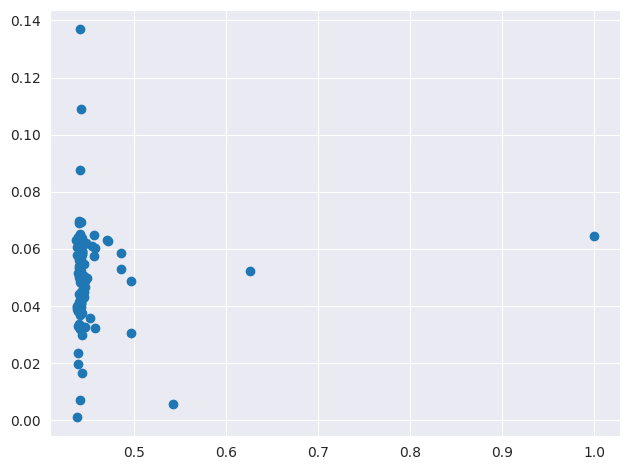

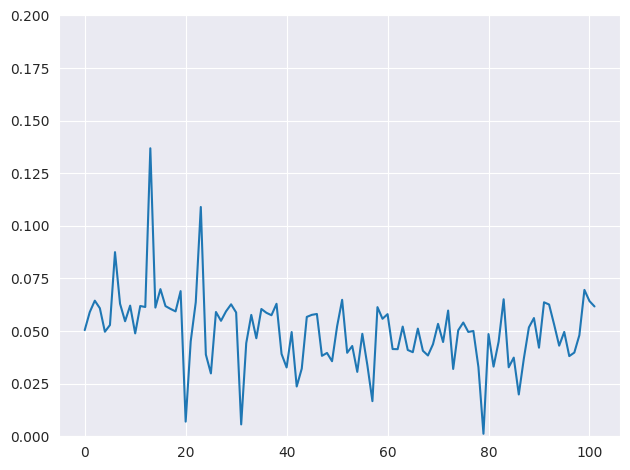

#### Training Dataset shape
(28941, 102)
#### Validation Dataset shape
(7236, 102)
#### Test Dataset shape
(9045, 102)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['sex']
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['age', 'education-num', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass=Federal-gov', 'workclass=Local-gov', 'workclass=Private', 'workclass=Self-emp-inc', 'workclass=Self-emp-not-inc', 'workclass=State-gov', 'workclass=Without-pay', 'education=10th', 'education=11th', 'education=12th', 'education=1st-4th', 'education=5th-6th', 'education=7th-8th', 'education=9th', 'education=Assoc-acdm', 'education=Assoc-voc', 'education=Bachelors', 'education=Doctorate', 'education=HS-grad', 'education=Masters', 'education=Preschool', 'education=Prof-school', 'education=Some-college', 'marital-status=Divorced', 'marital-status=Married-AF-spouse', 'marital-status=Marr

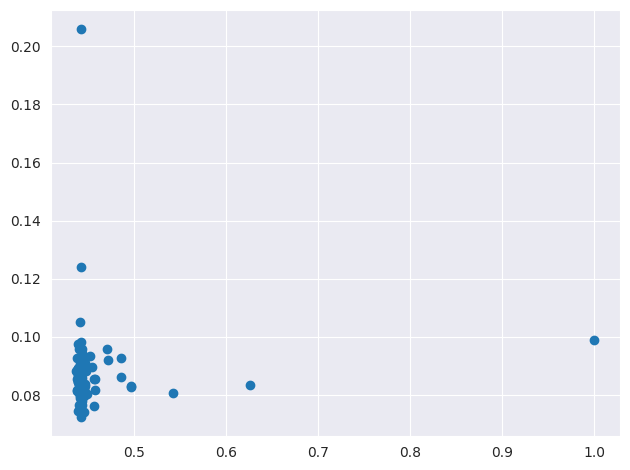

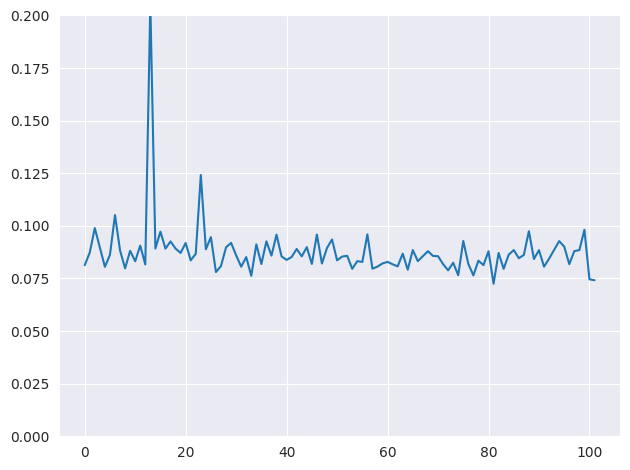

In [6]:
result, prediction, logits, corr = train_model(adult_dataset_reader, mlp_xi_reg_initializer, corr=None)
result, prediction, logits, _ = train_model(adult_dataset_reader, simple_mlp_initializer, corr)
